In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pylhe

from Mu3e import plot_tools, const, models

2023-11-30 13:16:26.383097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Define the path to the MadGraph directory
path_to_madgraph = os.path.expanduser('~/Development/MG5_aMC_v3_5_0')  # NOTE: Change this to your MadGraph installation path
notebook_path = os.getcwd( )

In [4]:
def get_events(filename):
    mg5events = pylhe.read_lhe_with_attributes(filename)

    # Create akward array objects for convinience
    mg5events = pylhe.to_awkward(mg5events)

    return mg5events

def get_spectrum_in_bins(p, bins, weights = None):
    di, _ = np.histogram(p, bins, weights = weights)
    return np.array(di)

## MadGraph functions

In [5]:
def get_mgevents_mucapture(model, process='mu- pp > vm chi1 e+ e-', output='MuonCaptureModel1', generate=True, HTML_opening=False, nevents=1e3):

    if model.muon_capture_open:
        full_output_path = f'{notebook_path}/MGevents/{output}'
        custom_name = f'custom_run_{model.m1:.2e}_{model.m2:.2e}_{model.maprime:.2e}'
        
        # Create a command file with all the instructions for MadGraph
        mg5_commands = f"""
        set automatic_html_opening {HTML_opening}
        import model ExoticMuonCaptureModel1
        generate {process} QEDp<=5
        output {full_output_path}
        launch -n {custom_name} {full_output_path} 
        0
        set ptl -1
        set etal -1
        set etalmin -1
        set drll -1
        set nevents 50000
        set ebeam1 0.00001
        set ebeam2 0.00001
        set Mchi1 {model.m1:.2e}
        set Mchi2 {model.m2:.2e}
        set MAp {model.maprime:.2e}
        set nevents {int(nevents)}"
        0
        """

        if generate:
            # Save the commands to a file
            with open('mg5_script.txt', 'w') as file:
                file.write(mg5_commands)

            # Run the MadGraph script
            os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt > {notebook_path}/MGevents/MGlogfile.txt')

        # Move the LHE events to the desired path
        lhe_file_path = f'{full_output_path}/Events/{custom_name}/unweighted_events.lhe.gz'
        
        # Collect events after unzipping
        return get_events(lhe_file_path)
    else:
        print("Muon capture kinematically forbidden.")
        return None

In [6]:
def get_mgevents_pdecay(model, process='pp > e+ vm~ ve vm chi1 e+ e-', output='ProtonDecayModel1', generate=True, HTML_opening=False, nevents=1e3):
    
    if len(model.get_open_pdecay_channels()) > 1:
        print("Decay channels:", model.get_open_pdecay_channels())
        # raise ValueError('Multiple proton decay channels detected')

    full_output_path = f'{notebook_path}/MGevents/{output}'
    custom_name = f'custom_run_{model.m1:.2e}_{model.m2:.2e}_{model.maprime:.2e}'
    
    # Create a command file with all the instructions for MadGraph
    mg5_commands = f"""
    set automatic_html_opening {HTML_opening}
    import model ExoticMuonCaptureModel1
    generate {process} QEDp<=5
    output {full_output_path}
    launch -n {custom_name} {full_output_path} 
    0
    set Mchi1 {model.m1:.2e}
    set Mchi2 {model.m2:.2e}
    set MAp {model.maprime:.2e}
    set nevents {int(nevents)}"
    0
    """

    if generate:
        # Save the commands to a file
        with open('mg5_script.txt', 'w') as file:
            file.write(mg5_commands)

        # Run the MadGraph script
        os.system(f'{path_to_madgraph}/bin/mg5_aMC mg5_script.txt > {notebook_path}/MGevents/MGlogfile.txt')

    # Move the LHE events to the desired path
    lhe_file_path = f'{full_output_path}/Events/{custom_name}/unweighted_events.lhe.gz'
    
    # Collect events after unzipping
    return get_events(lhe_file_path)

## Model benchmarks

In [7]:
Lambda_NP = 1e6
Gmup = 1/(Lambda_NP)**2

Benchmark1 = models.MuonCaptureModelI(m1=0.900, m2=1.020, maprime=0.020, Gmup=Gmup)
Benchmark2 = models.MuonCaptureModelI(m1=0.835, m2=1.020, maprime=0.020, Gmup=Gmup)

## Muon capture studies

In [8]:
mucapture_1 = get_mgevents_mucapture(Benchmark1, generate=True, nevents=1e3)
mucapture_2 = get_mgevents_mucapture(Benchmark2, generate=True, nevents=1e3)

weights_mucapture_1 = mucapture_1['eventinfo','weight'].to_numpy()/mucapture_1['eventinfo','weight'].to_numpy().sum() * Benchmark1.get_mu_capture_rate()
weights_mucapture_2 = mucapture_1['eventinfo','weight'].to_numpy()/mucapture_1['eventinfo','weight'].to_numpy().sum() * Benchmark2.get_mu_capture_rate()

stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 23682.11it/s]
stty: stdin isn't a terminal
100%|██████████| 774/774 [00:00<00:00, 33017.62it/s]


In [9]:
def mu_capture_kinematics(mgevents):
    electrons = (mgevents['particles', 'id'] == 11)
    positrons = (mgevents['particles', 'id'] == -11)
    neutrinos = (np.abs(mgevents['particles', 'id']) == 12) | (np.abs(mgevents['particles', 'id']) == 14)
    chi1s = (np.abs(mgevents['particles', 'id']) == 999901) 

    p_positron = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    p_electron = np.array([np.array(mgevents["particles", "vector", ind][electrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    ptot = (p_positron + p_electron).T

    kin = {}
    kin['E_positron'] = mgevents['particles','vector','t'][positrons].to_numpy().sum(axis=1)
    kin['E_electron'] = mgevents['particles','vector','t'][electrons].to_numpy().sum(axis=1)
    kin['E_neutrino'] = mgevents['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
    kin['E_chi1'] = mgevents['particles','vector','t'][chi1s].to_numpy().sum(axis=1)
    kin['E_vis'] = kin['E_electron'] + kin['E_positron']
    kin['T_vis'] = kin['E_vis'] - 2*const.m_e
    kin['E_inv'] = kin['E_neutrino'] + kin['E_chi1']
    kin['E_asy'] = np.abs(kin['E_electron'] - kin['E_positron']) / (kin['E_electron'] + kin['E_positron'])
    kin['m_ee'] = np.sqrt(ptot[:, 0]**2 - ptot[:, 1]**2 - ptot[:, 2]**2 - ptot[:, 3]**2)

    return kin

In [10]:
kin_1 = mu_capture_kinematics(mucapture_1)
kin_2 = mu_capture_kinematics(mucapture_2)

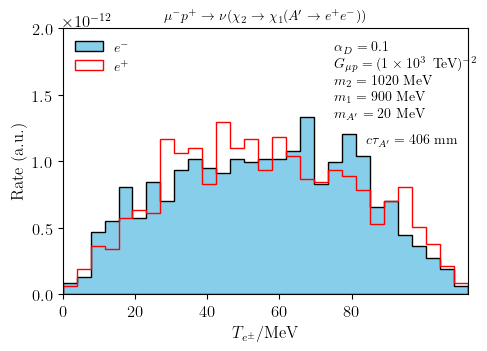

In [11]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

bins = np.linspace(0, max(np.max(kin_1['E_electron']), np.max(kin_1['E_positron']))*1e3, 30)

# Plot the histogram
ax.hist((kin_1['E_electron']-const.m_e)*1e3, weights=weights_mucapture_1/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black', label='$e^-$')

# Plot the histogram
ax.hist((kin_1['E_positron']-const.m_e)*1e3, weights=weights_mucapture_1/np.diff(bins)[0], bins=bins, histtype='step', color='skyblue', edgecolor='red', label='$e^+$')

# Set labels and title
ax.set_xlabel(r'$T_{e^\pm}$/MeV')
ax.set_ylabel(r'Rate (a.u.)')
ax.set_title(fr'$\mu^- p^+ \to \nu (\chi_2 \to \chi_1 (A^\prime \to e^+e^-))$', fontsize=10)

# ax.set_yscale('log')
ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.67, 0.95, Benchmark1.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

ax.text(0.75, 0.6, fr'$c\tau_{{A^\prime}} = {Benchmark1.get_aprime_ctau0():.0f}$~mm', transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.legend(loc='upper left', fontsize=10, frameon=False)

# Add the vertical dashed line
# sqrts = (mp + mmu)
# Echi2_CM = (sqrts**2 + mchi2**2)/2/sqrts
# Echi1_max = (sqrts**2 + mchi1**2 - (2*me)**2)/2/sqrts
# Ee_max = (Echi2_CM**2 + me**2 - (me + mchi1)**2)/2/Echi2_CM
# cutoff = Ee_max
# ax.axvline(cutoff, linestyle='dashed', color='grey', alpha=0.2)
# ax.text(cutoff+2, ax.get_ylim()[1]/20, r'$\frac{ E_{\chi_2}^{\rm CM\,2} + m_e^2 - (m_e + m_1)^2}{2E^{\rm CM}_{\chi_2}}$', rotation='vertical', color='grey', ha='left', va='bottom')

# Set x ticks
ax.set_xticks(np.arange(0, 100, 20))
ax.set_ylim(0,20e-13)

# Save the figure to a PDF file
fig.savefig(f'plots/MuonCapture_model1_m1_{Benchmark1.m1*1e3:.0f}_Tvis.png', bbox_inches='tight', dpi=300)

## Proton decay studies

In [12]:
pdecay_full_1 = get_mgevents_pdecay(Benchmark1, generate=True, process='pp > e+ vm~ ve vm chi1 e+ e-')
weights_full_1 = const.get_decay_rate_in_1e32_years(pdecay_full_1['eventinfo','weight'].to_numpy() / len(pdecay_full_1)) * Benchmark1.pdecay_rescale

lifetime_1e32_1 = weights_full_1.sum()
lifetime_1e32_1

stty: stdin isn't a terminal
100%|██████████| 978/978 [00:00<00:00, 33063.02it/s]


2.2267203782178013e-33

In [13]:
pdecay_aprime_1 = get_mgevents_pdecay(Benchmark1, generate=True, process='pp > e+ vm~ ve vm chi1 Ap')
weights_aprime_1 = const.get_decay_rate_in_1e32_years(pdecay_aprime_1['eventinfo','weight'].to_numpy() / len(pdecay_aprime_1)) * Benchmark1.pdecay_rescale

lifetime_1e32_aprime_1 = weights_aprime_1.sum()
lifetime_1e32_aprime_1

stty: stdin isn't a terminal
100%|██████████| 904/904 [00:00<00:00, 60391.03it/s]


3.6575886447008227e-40

In [14]:
print(lifetime_1e32_1)
print(lifetime_1e32_aprime_1)
weights_full_normalized = weights_full_1 * lifetime_1e32_aprime_1 / lifetime_1e32_1

2.2267203782178013e-33
3.6575886447008227e-40


In [15]:
def p_decay_kinematics(mgevents):
    electrons = (mgevents['particles', 'id'] == 11)
    positrons = (mgevents['particles', 'id'] == -11)
    neutrinos = (np.abs(mgevents['particles', 'id']) == 12) | (np.abs(mgevents['particles', 'id']) == 14)
    chi1s = (np.abs(mgevents['particles', 'id']) == 999901) 

    p_positron_1 = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    p_positron_2 = np.array([np.array(mgevents["particles", "vector", ind][positrons]) for ind in ["t", "x", "y", "z"]])[:,:,1]
    p_electron = np.array([np.array(mgevents["particles", "vector", ind][electrons]) for ind in ["t", "x", "y", "z"]])[:,:,0]
    ptot = (p_positron_1 + p_positron_2 + p_electron).T

    kin = {}
    kin['E_positrons'] = mgevents['particles','vector','t'][positrons].to_numpy().sum(axis=1)
    kin['E_electrons'] = mgevents['particles','vector','t'][electrons].to_numpy().sum(axis=1)
    kin['E_neutrinos'] = mgevents['particles','vector','t'][neutrinos].to_numpy().sum(axis=1)
    kin['E_chi1'] = mgevents['particles','vector','t'][chi1s].to_numpy().sum(axis=1)
    kin['E_vis'] = kin['E_electrons'] + kin['E_positrons']
    kin['T_vis'] = kin['E_vis'] - 2*const.m_e
    kin['E_inv'] = kin['E_neutrinos'] + kin['E_chi1']
    kin['E_asy'] = np.abs(kin['E_electrons'] - kin['E_positrons']) / (kin['E_electrons'] + kin['E_positrons'])
    kin['m_eee'] = np.sqrt(ptot[:, 0]**2 - ptot[:, 1]**2 - ptot[:, 2]**2 - ptot[:, 3]**2)

    return kin


In [16]:
kin_pdecay = p_decay_kinematics(pdecay_full_1)

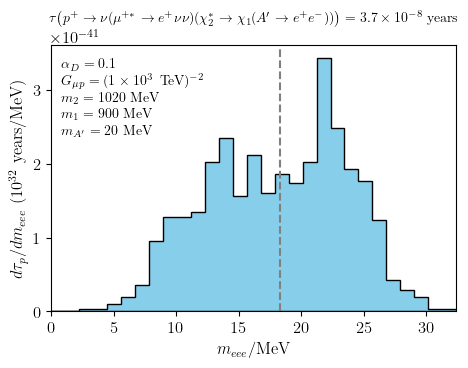

In [17]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, np.max(kin_pdecay['m_eee'])*1e3, 30)
ax.hist(kin_pdecay['m_eee']*1e3, weights=weights_full_normalized/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$m_{eee}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d m_{eee}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_1.sum()*1e32, notex=True)}$ years', fontsize=10)

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark1.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')


# Add the vertical dashed line
cutoff = (const.m_proton - Benchmark1.m1 - Benchmark1.maprime)*1e3
ax.axvline(cutoff, linestyle='dashed', color='grey')
# ax.text(cutoff+0.5, ax.get_ylim()[1]/10, r'$m_p - m_1 - 3 m_e$', rotation='vertical', color='grey', ha='left', va='bottom')


# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_meee_m1_{Benchmark1.m1:0.0f}.png', bbox_inches='tight', dpi=300)

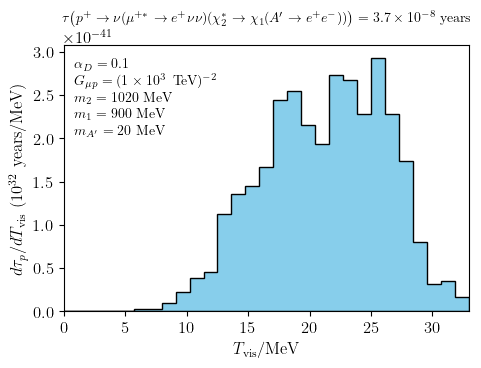

In [18]:
# Create a figure and axis
fig, ax = plot_tools.std_fig(figsize=(5, 3.5))

# Plot the histogram
bins = np.linspace(0, np.max(kin_pdecay['T_vis']*1e3), 30)
ax.hist(kin_pdecay['T_vis']*1e3, weights=weights_full_normalized/np.diff(bins)[0], bins=bins, histtype='stepfilled', color='skyblue', edgecolor='black')

# Set labels and title
ax.set_xlabel(r'$T_{\mathrm{vis}}$/MeV')
ax.set_ylabel(r'${d \tau_{p}/d T_{\rm vis}}$ ($10^{32}$ years/MeV)')
ax.set_title(fr'$\tau\big(p^+ \to \nu(\mu^{{+*}} \to e^+\nu\nu)(\chi_2^* \to \chi_1 (A^\prime \to e^+e^-))\big) = {plot_tools.sci_notation(lifetime_1e32_aprime_1*1e32, notex=True)}$ years', fontsize=10)

# ax.set_yscale('log')

ax.set_xlim(np.min(bins),np.max(bins))

# Add the text box
ax.text(0.025, 0.95, Benchmark1.text_descriptor, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Add the vertical dashed line
# cutoff = 938.27 - (m1+mAp)*1e3 - 3*0.511
# ax.axvline(cutoff, linestyle='dashed', color='grey')
# ax.text(cutoff+0.5, ax.get_ylim()[1]/10, r'$m_p - m_1 - 3 m_e$', rotation='vertical', color='grey', ha='left', va='bottom')

# Save the figure to a PDF file
fig.savefig(f'plots/ProtonDecay_model1_Tvis_m1_{Benchmark1.m1:0.0f}.png', bbox_inches='tight', dpi=300)